# Heuristic reward with PPO agent

2023-04-22 11:28:46.001558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


array(['S watermelon punch (without milks)', 'Dried persimmon',
       'S kyogo grape (100g)', ..., 'Green onion kimchi',
       'Pickled paprika', 'empty'], dtype='<U72')

array(['Fruits (snack)', 'Fruits (snack)', 'Fruits (snack)', ...,
       'Kimchi', 'Kimchi', 'Others'], dtype='<U18')

,Energy,Protein,Fat,Carbohydrate,Total Dietary,Calcium,Iron,Sodium,Vitamin A,Vitamin B1 (Thiamine),Vitamin B2 (Rivoflavin),Vitamin C,Linoleic Acid,Alpha-Linolenic Acid
S watermelon punch (without milks),55.00,0.7900,0.05000,13.8180,0.200,7.200,0.18600,0.600,71.083333,0.024000,0.03000,0.0000,14.2500,2.9300
Dried persimmon,76.50,0.5820,0.04800,20.5830,3.360,6.300,0.19200,0.900,13.725000,0.003000,0.06720,1.5330,0.0000,8.6010
S kyogo grape (100g),61.00,0.4300,0.04000,16.3800,0.400,4.000,0.17000,1.000,2.166667,0.026000,0.04700,0.1300,11.8900,6.0900
S dried persimmon,85.60,0.7720,0.03200,22.9800,3.400,5.600,0.24800,0.400,9.533333,0.003600,0.09720,1.0680,0.0000,5.0440
S fruit punch,101.05,3.6700,3.36450,14.8900,0.790,117.650,0.19850,36.000,91.166667,0.040350,0.19110,1.8925,86.6605,10.6925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ponytail radish kimchi,10.25,0.5050,0.05000,1.9725,0.775,10.500,0.16750,173.000,5.541667,0.003250,0.01900,0.4125,19.7050,9.4775
Kohlrabi watery kimchi,5.50,0.2900,0.01250,1.2900,0.600,10.500,0.06750,1.750,0.250000,0.203750,0.00875,0.0000,1.9650,5.1100
Green onion kimchi,12.25,0.6250,0.14500,2.1275,1.150,15.000,0.18250,163.750,26.854167,0.012750,0.02850,0.5550,79.8050,17.1425
Pickled paprika,7.94,0.2017,0.03005,1.9859,0.348,1.675,0.08145,67.204,4.850000,0.003675,0.02709,24.2820,12.4483,6.5448


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step: 21
Chosen Meal: Braised chicken(breast) in teriyaki sauce
Chosen Meal Category: Braised
Meal History: ['Seasoned salad with bokchoy in vinegar marinade'
 'Roasted pork with sweet rice' 'Braised lotus root in sweet soy sauce'
 'Seasoned salad with lettuce in vinegar marinade'
 'Chicken vegetable stew' 'Seasoned salad with cucumber and paprika'
 'S sweet pumpkin rice cake-based cake'
 'Seasoned salad with spinach and salted seaweed'
 'Beef soup with boiled napa cabbage' 'Steamed eggs with winter celery'
 'Steamed winter celery with rice cake in red chilli paste'
 'Chuncheon-style stir-fried chicken' 'S dried pollack veggie porridge'
 'Stir-fried beef and garlic stalk' 'Korean beef pancake with tofu'
 'Little neck clam soy paste soup' 'S potato vagetable porridge'
 'S milk bread roll' 'Seasoned salad with apple and chicory'
 'Braised chilli pepper and dried pollack in soy sauce'
 'Braised c

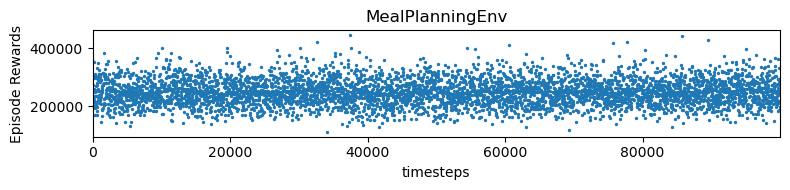

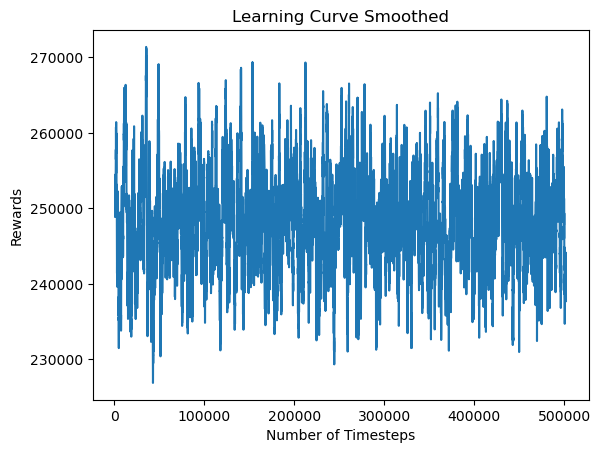

In [1]:
from stable_baselines3 import PPO
import numpy as np
import pandas as pd
from heuristic_environment import MealPlanningEnv
from dietkit import load_ingredient, load_menu, load_diet
import matplotlib.pyplot as plt

import os 
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter


log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()


all_ingredients = load_ingredient(sample_language='eng')
meal_dict = load_menu(
    ingredients=all_ingredients,
    sample_language='eng'
)
example_mealplans = load_diet(
    menus=meal_dict, 
    num_loads=100, 
    sample_language='eng', 
    sample_name='ML'
)

possible_meals = np.array(list(meal_dict.keys()))
display(possible_meals)

meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
display(meal_categories)

nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)
display(nutrition_data)


num_meals = 21
env = MealPlanningEnv(
  possible_meals=possible_meals, 
  meal_categories=meal_categories,
  nutrition_data=nutrition_data, 
  num_meals=num_meals
)
model = PPO("MultiInputPolicy", env, verbose=1)
obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
env.render()
model.learn(total_timesteps=10000)

obs = env.reset()
for _ in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
env.render()

results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "MealPlanningEnv"
)

plot_results(log_dir)

In [3]:
from collections import Counter
from scipy import stats

def entropy_of_sequence(input_list):
    # get counts
    count_data = list(Counter(input_list).values())
    
    # get entropy from counts
    entropy = stats.entropy(count_data)  
    
    return entropy

print(entropy_of_sequence([1,2,3]))
print(entropy_of_sequence([1,1,2]))
print(entropy_of_sequence([2,1,1]))
print(entropy_of_sequence([1,1,1]))

1.0986122886681096
0.6365141682948128
0.6365141682948128
0.0


In [2]:
obs = env.reset()
for _ in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
num_unique_categories_chosen = len(np.unique(env.category_history))
print(f'Num possible unique categories: {env.unique_meal_categories}')
print(f'Num unique categories chosen: {num_unique_categories_chosen}')

Num possible unique categories: ['Braised' 'Cereal (snack)' 'Combo meal (snack)' 'Combo meal rice'
 'Deep fried' 'Drink (snack)' 'Fruits (snack)' 'Grains (snack)' 'Grilled'
 'Kimchi' 'Milk (snack)' 'Noodles' 'Nuts (snack)' 'Others' 'Pancake'
 'Rice' 'Salad' 'Salad (snack)' 'Soup' 'Soup (snack)' 'Steamed'
 'Stir-fried' 'empty']
Num unique categories chosen: 11
